## 1. Setup and Load Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv(r'D:\Python task\Accredian\Fraud.csv')
# Quick overview of the data
print(df.head())
print(df.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

## 3. Data Cleaning

In [3]:
# Check for missing values
print(df.isnull().sum())

# Drop duplicates (if any)
df = df.drop_duplicates()

# Check for any incorrect data types
print(df.dtypes)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


## 4. Exploratory Data Analysis (EDA)

##### Transaction Types Breakdown

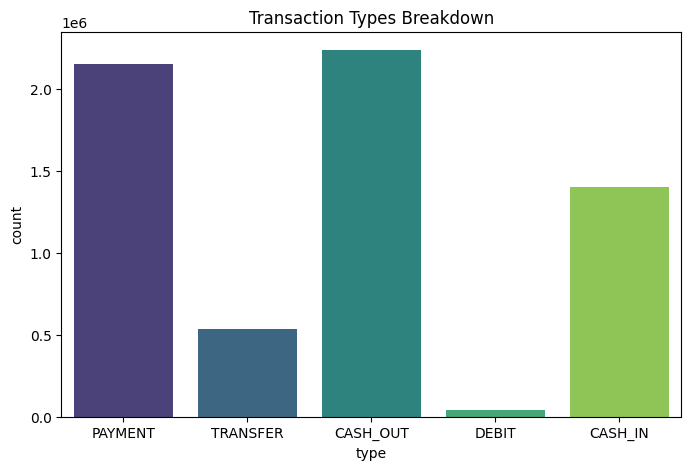

In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='viridis')
plt.title('Transaction Types Breakdown')
plt.show()

##### Fraud Analysis by Transaction Type

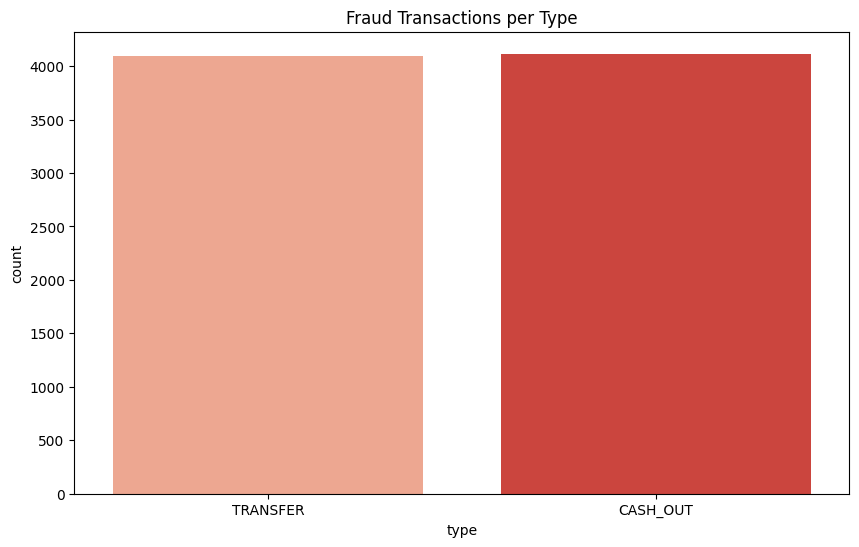

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['isFraud'] == 1], x='type', palette='Reds')
plt.title('Fraud Transactions per Type')
plt.show()

## 5. Feature Engineering

In [6]:
# Balance difference features
df['balance_diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Ratio of transaction amount to original balance
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

## 6. Encoding Categorical Data

In [7]:
# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)


## 7. Split Data for Training and Testing

In [8]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 8. Build Machine Learning Models

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, min_samples_split=5, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


## 9. Evaluate the Model

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Model evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))


Accuracy: 0.9999811398449067
Precision: 0.9993742177722152
Recall: 0.9858024691358025
F1 Score: 0.9925419515226849
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      0.99      0.99      1620

    accuracy                           1.00   1272524
   macro avg       1.00      0.99      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



##### For a Confusion Matrix:

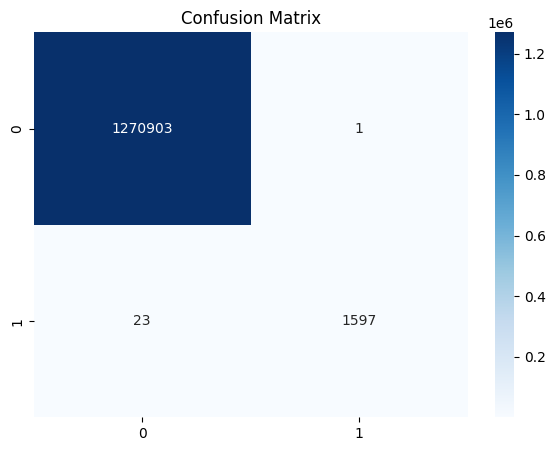

In [15]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 10. Feature Importance Analysis

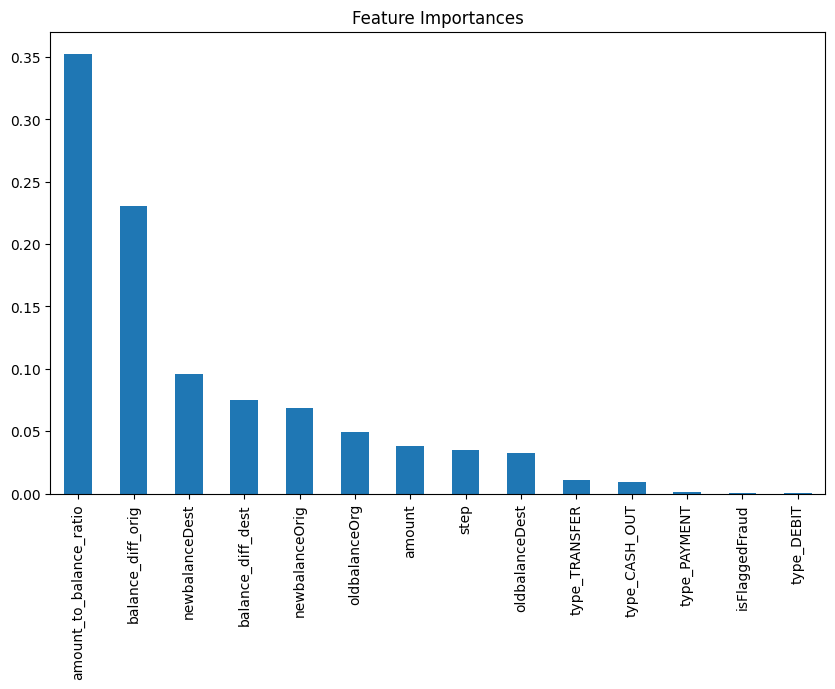

In [16]:
# Feature Importance Plot
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()

## Step 11: Fraud Prevention Recommendations

##### 1. Real-Time Transaction Monitoring

In [17]:
def flag_suspicious_transaction(row):
    # Rule: Flag transfers or cash-outs with high amounts or sudden balance drops
    if row['type_TRANSFER'] == 1 and row['amount'] > 200000:
        return 1
    if row['type_CASH_OUT'] == 1 and row['balance_diff_orig'] < -0.9 * row['oldbalanceOrg']:
        return 1
    return 0

# Apply rules to the dataset
df['suspicious_flag'] = df.apply(flag_suspicious_transaction, axis=1)

# Count flagged transactions
print(f"Suspicious Transactions Flagged: {df['suspicious_flag'].sum()}")


Suspicious Transactions Flagged: 1387284


##### 2. Multi-Factor Authentication (MFA)

In [18]:
def enforce_mfa(row):
    if row['suspicious_flag'] == 1:
        return 'MFA required'
    return 'Proceed normally'

# Apply MFA enforcement
df['mfa_status'] = df.apply(enforce_mfa, axis=1)

# Check results
df[['amount', 'type_TRANSFER', 'type_CASH_OUT', 'suspicious_flag', 'mfa_status']].head(10)


,amount,type_TRANSFER,type_CASH_OUT,suspicious_flag,mfa_status
0,9839.64,False,False,0,Proceed normally
1,1864.28,False,False,0,Proceed normally
2,181.00,True,False,0,Proceed normally
3,181.00,False,True,1,MFA required
4,11668.14,False,False,0,Proceed normally
5,7817.71,False,False,0,Proceed normally
6,7107.77,False,False,0,Proceed normally
7,7861.64,False,False,0,Proceed normally
8,4024.36,False,False,0,Proceed normally
9,5337.77,False,False,0,Proceed normally


##### 3. Velocity Checks (Multiple Rapid Transactions)

In [19]:
# Sort transactions by customer and time
df = df.sort_values(by=['nameOrig', 'step'])

# Count rapid transactions per customer within a 3-step (hour) window
df['rapid_transactions'] = df.groupby('nameOrig')['step'].diff().fillna(100)
df['rapid_flag'] = (df['rapid_transactions'] <= 3).astype(int)

print(f"Rapid Transactions Flagged: {df['rapid_flag'].sum()}")


Rapid Transactions Flagged: 237


## Step 12: Measuring Success

##### 1. Define Success Metrics

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fraud Detection Rate
detection_rate = df[(df['isFraud'] == 1) & (df['suspicious_flag'] == 1)].shape[0] / df[df['isFraud'] == 1].shape[0]

# False Positive Rate
false_positive_rate = df[(df['isFraud'] == 0) & (df['suspicious_flag'] == 1)].shape[0] / df[df['isFraud'] == 0].shape[0]

# Precision, Recall, F1 Score
precision = precision_score(df['isFraud'], df['suspicious_flag'])
recall = recall_score(df['isFraud'], df['suspicious_flag'])
f1 = f1_score(df['isFraud'], df['suspicious_flag'])

print(f"Fraud Detection Rate: {detection_rate:.2%}")
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"Precision: {precision:.2%}, Recall: {recall:.2%}, F1 Score: {f1:.2%}")


Fraud Detection Rate: 83.01%
False Positive Rate: 21.72%
Precision: 0.49%, Recall: 83.01%, F1 Score: 0.98%


##### 2. Track Time to Detection (TTD)

In [21]:
# Time to detection: Steps between fraud transaction and first flag
df['detection_delay'] = df.apply(lambda row: row['step'] if row['suspicious_flag'] == 1 else 999, axis=1)
ttd = df[df['isFraud'] == 1]['detection_delay'].min()

print(f"Time to Detection (Steps): {ttd}")


Time to Detection (Steps): 1


##### 3. Monitor Customer Impact

In [22]:
# Count legitimate users wrongly flagged
false_positives = df[(df['isFraud'] == 0) & (df['suspicious_flag'] == 1)]['nameOrig'].nunique()
total_customers = df['nameOrig'].nunique()

customer_impact_rate = (false_positives / total_customers) * 100
print(f"Customer Impact Rate: {customer_impact_rate:.2f}%")


Customer Impact Rate: 21.72%
